In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
import re

# Sentiment Analysis

## Amazon

In [2]:
reviews = pd.read_csv('./amazon_cells_labelled.txt', sep='\t', header=None)
reviews.columns = ['review', 'score']

In [3]:
reviews.groupby("score").size()

score
0    500
1    500
dtype: int64

*So the classes are perfectly balanced.*

In [3]:
# lets determine which "buzzwords" are more frequent 
word_counts_positive = reviews.query("score == 1").review.str.split(expand=True).stack().value_counts()
word_counts_negative = reviews.query("score == 0").review.str.split(expand=True).stack().value_counts()
# get the words unique to negative review
words_negative = word_counts_negative.index.difference(word_counts_positive.index)
words_positive = word_counts_positive.index.difference(word_counts_negative.index)
x = word_counts_positive[words_positive].sort_values(ascending = False).head(20).index
pos_words = x.to_series().apply(str.lower).values
# also need to pull out the punctuation
y = word_counts_negative[words_negative].sort_values(ascending = False).head(20).index
neg_words = y.to_series().apply(str.lower).values
print("Positive Keywords: \n{}\n\nNegative Keywords:\n{}".format(pos_words, neg_words))

Positive Keywords: 
['great' 'works' 'love' 'best' 'works' 'good' 'nice' 'working' 'nice'
 'pretty' 'excellent' 'good.' 'fine' 'fine.' 'great!' 'data' 'job'
 'sturdy' 'far.' 'phone.']

Negative Keywords:
["don't" 'waste' 'not' 'worst' 'money' 'unit' "didn't" 'bad' 'difficult'
 'what' 'poor' 'poor.' "doesn't" 'return' 'week' 'do' 'broke' 'stay'
 'buying' 'unfortunately']


In [4]:
def percent_capitalized_words(review, return_number = False):
    # first we need to get each sentence
    pattern = re.compile("[A-Z]{2,}")
    words_to_ignore = ["US", "USA", "PC", "AC", "DC", "MP", "PDA",
                    "RAZR", "QWERTY", "BT", "DNA", "HS850", "OS"]
    found = 0  

    sentences = review.split('.')
    num_words = len(sentences)
    for sentence in sentences:
        words = sentence.split(' ') 
        for word in words:
            if word in words_to_ignore:
                continue
            if pattern.match(word):
                found += 1
    if return_number:
        return found
    else:
        return found / num_words

In [4]:
pos_words = ['great','works','love','best',
             'good','nice','working','excellent',
             'good','fine','sturdy']
neg_words = ["don't","waste","not","worst",
             "didn't","bad","difficult","poor",
             "doesn't","return","broke"]

In [5]:
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    reviews[str(word)] = reviews.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )

Let's add a few more.

In [6]:
# I would guess that positive reviews have more exclamation marks than negative ones
1 / (reviews.query("score == 0").review.str.contains("!").sum() / len(reviews))

27.027027027027028

In [7]:
1 / (reviews.query("score == 1").review.str.contains("!").sum() / len(reviews))

12.820512820512821

  * So essentially what this tells us is that 1 in every 12.8 **positive** reviews contain an exclamation mark, while only 1 in every 27 **negative** reviews contain an exclamation mark. Let's add this!
  * 1 in every 3 **positive** reviews is in all caps, while 2 in every 3 **negative** reviews are in all caps - so add this as well!

In [6]:
reviews['exclamation'] = reviews.review.str.contains("!")
# reviews["allcaps"] = reviews.review.str.isupper() too correlated with the below
reviews["percent_capitalized_words"] = reviews.review.apply(percent_capitalized_words)
reviews["num_capitalized_words"] = reviews.review.apply(lambda x: percent_capitalized_words(x, True))

In [12]:
features = list(neg_words) + list(pos_words) + ["exclamation", "percent_capitalized_words", "num_capitalized_words"]
data = reviews[features]
target = reviews['score']

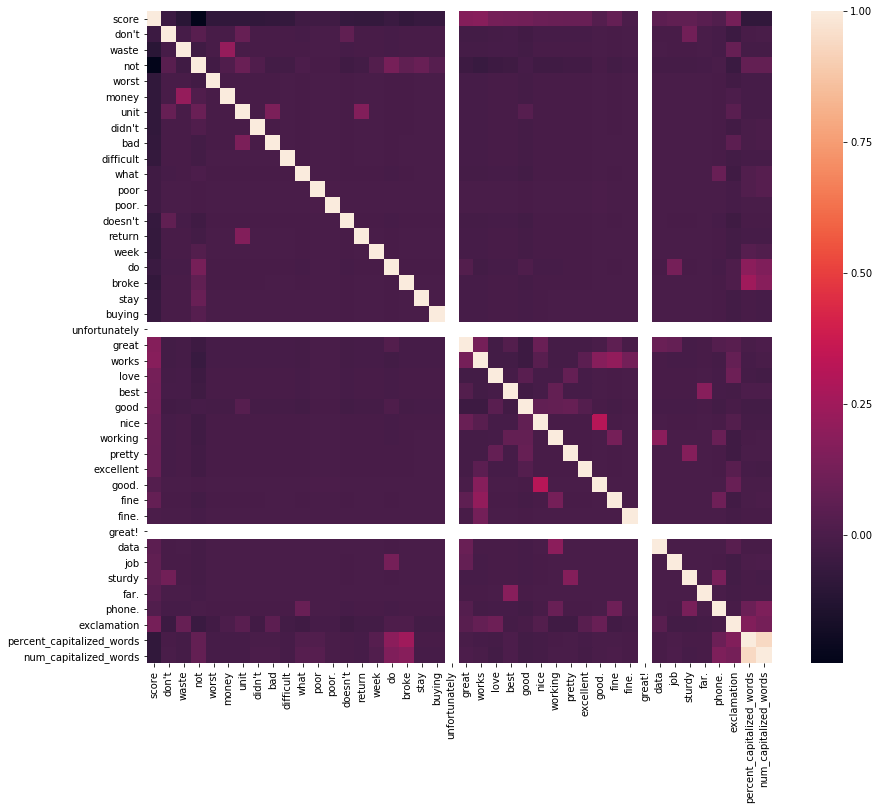

In [13]:
plt.figure(figsize=(14,12))
sns.heatmap(reviews.corr())
plt.show()

  * So our input words appear to be uncorrelated
  
  ### Model

In [31]:
# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
#y_pred = bnb.predict(data)
y_pred = cross_val_predict(bnb, data, target)

n = data.shape[0]
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    n,
    (target != y_pred).sum()
))

correct = (n - (target != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))

cv = cross_val_score(bnb, data, target, cv=5)
print(cv)
print("cv average is = {:.2f}%".format(cv.mean()*100))

cm = confusion_matrix(target, y_pred)
print(cm)
print("True Positive = {:.2f}%".format(cm[1,1]/10))
print("False Positive = {:.2f}%".format(cm[0,1]/10))
print("True Negative = {:.2f}%".format(cm[0,0]/10))
print("False Negative = {:.2f}%".format(cm[1,0]/10))
print("sensitivity or hit rate is {:.2f}%".format(cm[1,1]/(cm[1,0]+cm[1,1])*100))
# sensitivity (recall) is the percentage of positives identified or TP/FN+TP
print("specificity or True Negative rate is {:.2f}%".format(cm[0,0]/(cm[0,0]+cm[0,1])*100))

Number of mislabeled points out of a total 1000 points : 328
Accuracy: 67.2%
[0.72  0.675 0.68  0.67  0.62 ]
cv average is = 67.30%
[[467  33]
 [295 205]]
True Positive = 20.50%
False Positive = 3.30%
True Negative = 46.70%
False Negative = 29.50%
sensitivity or hit rate is 41.00%
specificity or True Negative rate is 93.40%


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


  * Using the average of cross-validation accuracies will give us a better indicator of overall accuracy, and for Amazon reviews the accuracy is **67.3 %**
  
  

# Now we will use the same model on other company reviews

## IMDB

In [16]:
imdb = pd.read_csv('./imdb_labelled.txt', sep='\t', header=None)
imdb.columns = ['review', 'score']
# This is going to use the same features as the model built for Amazon reviews, 
# but on the IMDB data
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb[str(word)] = imdb.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    imdb[str(word)] = imdb.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
imdb['exclamation'] = imdb.review.str.contains("!")
# reviews["allcaps"] = reviews.review.str.isupper() too correlated with the below
imdb["percent_capitalized_words"] = imdb.review.apply(percent_capitalized_words)
imdb["num_capitalized_words"] = imdb.review.apply(lambda x: percent_capitalized_words(x, True))
data_imdb = imdb[features]
target_imdb = imdb['score']

  * So difficult and sturdy do not show up in any IMDB reviews, and there are a few more words that are correlated (which could be an issue for our model, however none of the correlations appear to be greater than 0.5)

In [30]:
y_pred = cross_val_predict(bnb, data_imdb, target_imdb)

n = data.shape[0]
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    n,
    (target_imdb != y_pred).sum()
))

correct = (n - (target_imdb != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))

cv = cross_val_score(bnb, data_imdb, target_imdb, cv=5)
print(cv)
print("cv average is = {:.2f}%".format(cv.mean()*100))

cm = confusion_matrix(target_imdb, y_pred)
print(cm)
print("True Positive = {:.2f}%".format(cm[1,1]/10))
print("False Positive = {:.2f}%".format(cm[0,1]/10))
print("True Negative = {:.2f}%".format(cm[0,0]/10))
print("False Negative = {:.2f}%".format(cm[1,0]/10))
print("sensitivity or hit rate is {:.2f}%".format(cm[1,1]/(cm[1,0]+cm[1,1])*100))
# sensitivity (recall) is the percentage of positives identified or TP/FN+TP
print("specificity or True Negative rate is {:.2f}%".format(cm[0,0]/(cm[0,0]+cm[0,1])*100))

Number of mislabeled points out of a total 1000 points : 316
Accuracy: 68.4%
[0.62251656 0.58666667 0.59731544 0.59060403 0.60402685]
cv average is = 60.02%
[[102 260]
 [ 56 330]]
True Positive = 33.00%
False Positive = 26.00%
True Negative = 10.20%
False Negative = 5.60%
sensitivity or hit rate is 85.49%
specificity or True Negative rate is 28.18%


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


* This model is roughly **68.4%** accurate, slightly better than on Amazon reviews, but when we use the average of the cross-validation scores the accuracy comes down to **60.02 %**

## Yelp

In [22]:
yelp = pd.read_csv('./yelp_labelled.txt', sep='\t', header=None)
yelp.columns = ['review', 'score']
# This is going to use the same features as the model built for Amazon reviews, 
# but on the IMDB data
for word in neg_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp[str(word)] = yelp.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
for word in pos_words:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp[str(word)] = yelp.review.str.contains(
        ' ' + str(word) + ' ',
        case=False
    )
    
yelp['exclamation'] = yelp.review.str.contains("!")
# reviews["allcaps"] = reviews.review.str.isupper() too correlated with the below
yelp["percent_capitalized_words"] = yelp.review.apply(percent_capitalized_words)
yelp["num_capitalized_words"] = yelp.review.apply(lambda x: percent_capitalized_words(x, True))
data_yelp = yelp[features]
target_yelp = yelp['score']

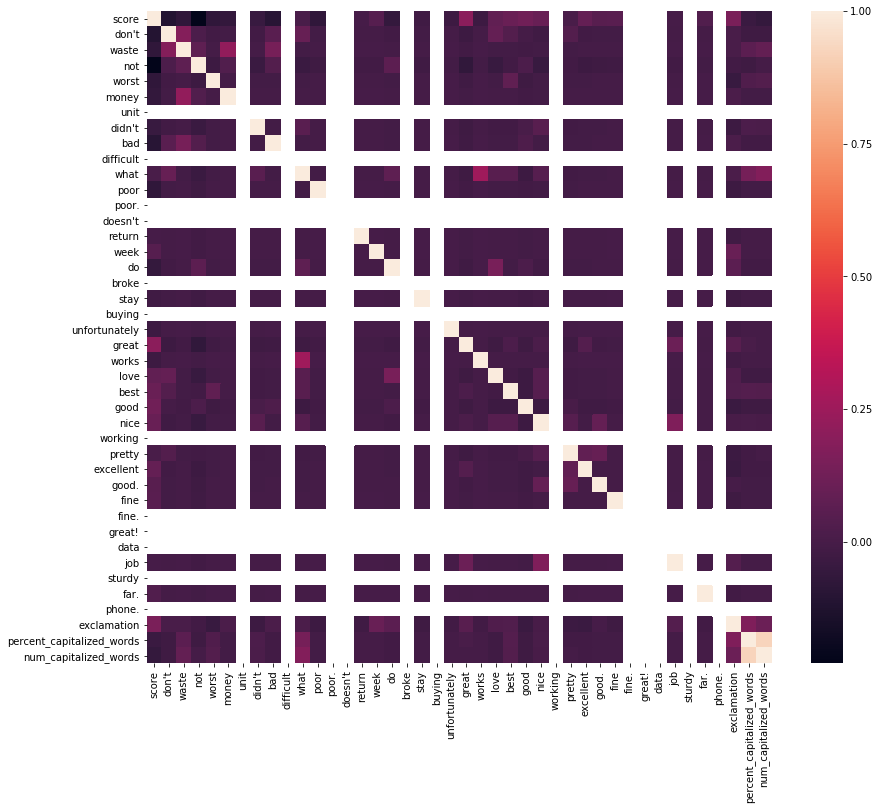

In [23]:
plt.figure(figsize=(14,12))
sns.heatmap(yelp.corr())
plt.show()

  * Yelp reviews do not contain the words difficult, doesn't, broke, working or sturdy
  * otherwise appear to be uncorrelated

In [28]:
y_pred = cross_val_predict(bnb, data_yelp, target_yelp)

n = data.shape[0]
# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    n,
    (target_yelp != y_pred).sum()
))

correct = (n - (target_yelp != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))

correct = (n - (target_yelp != y_pred).sum())/n * 100
print("Accuracy: {}%".format(correct))


cv = cross_val_score(bnb, data_yelp, target_yelp, cv=5)
print(cv)
print("cv average is = {:.2f}%".format(cv.mean()*100))

cm = confusion_matrix(target_yelp, y_pred)
print(cm)
print("True Positive = {:.2f}%".format(cm[1,1]/10))
print("False Positive = {:.2f}%".format(cm[0,1]/10))
print("True Negative = {:.2f}%".format(cm[0,0]/10))
print("False Negative = {:.2f}%".format(cm[1,0]/10))
print("sensitivity or hit rate is {:.2f}%".format(cm[1,1]/(cm[1,0]+cm[1,1])*100))
# sensitivity (recall) is the percentage of positives identified or TP/FN+TP
print("specificity or True Negative rate is {:.2f}%".format(cm[0,0]/(cm[0,0]+cm[0,1])*100))

Number of mislabeled points out of a total 1000 points : 339
Accuracy: 66.10000000000001%
Accuracy: 66.10000000000001%
[0.67  0.655 0.615 0.71  0.635]
cv average is = 65.70%
[[446  54]
 [285 215]]
True Positive = 21.50%
False Positive = 5.40%
True Negative = 44.60%
False Negative = 28.50%
sensitivity or hit rate is 43.00%
specificity or True Negative rate is 89.20%


/Users/mitchellmurphy/anaconda3/envs/python3.5/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


  * This model is roughly **66.1%** accurate, slightly below the accuracy on Amazon reviews, however the average score when using 5-fold cross validation is **65.7 %**
  
  # Conclusion
  
  We constructed a Naive Bayes classification model by simply using the top frequently used words that were unique to positive and negative reviews, as well as if a review contains an exclamation mark and if the review is all caps (using Amazon reviews). Here were the accuracy rates for each dataset:
    1. Amazon: 67.3%
    2. IMDB: 60.02%
    3. Yelp: 65.7%
    
  So when we do not use cross-validation, model that we constructed to classify Amazon reviews actually performs better on IMDB reviews, however when using the 5-fold cross-validation average the performance on the various datasets makes more sense. 